In [1]:
%load_ext autoreload
%autoreload 2

# Experiments on Toy Data

In [2]:
from aggregation import experiment
import numpy as np

mses, cates = experiment(4, n=500, random_state=3)

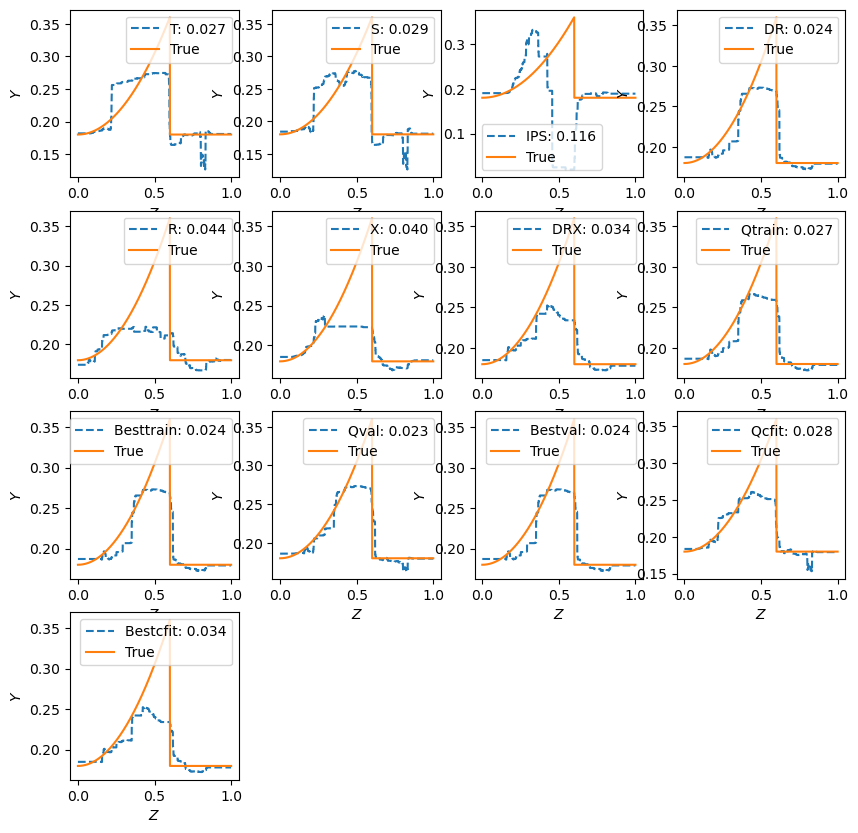

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(4, 4, it + 1)
    plt.plot(cates['Ztest'], cates[name], '--', label=f'{name}: {np.sqrt(mse):.3f}')
    plt.plot(cates['Ztest'], cates['True'], '-', label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [4]:
from aggregation import experiment
import numpy as np
import joblib
from joblib import Parallel, delayed 

all_results = {}
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        all_results[(n, dgp)] = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=n,
                                                                              random_state=it)
                                                          for it in range(100))
        joblib.dump(all_results, 'all_results.jbl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 17.0min remaining:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 405.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 19.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 16.8min remaining:   53.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 17.0min remaining:   53.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Paral

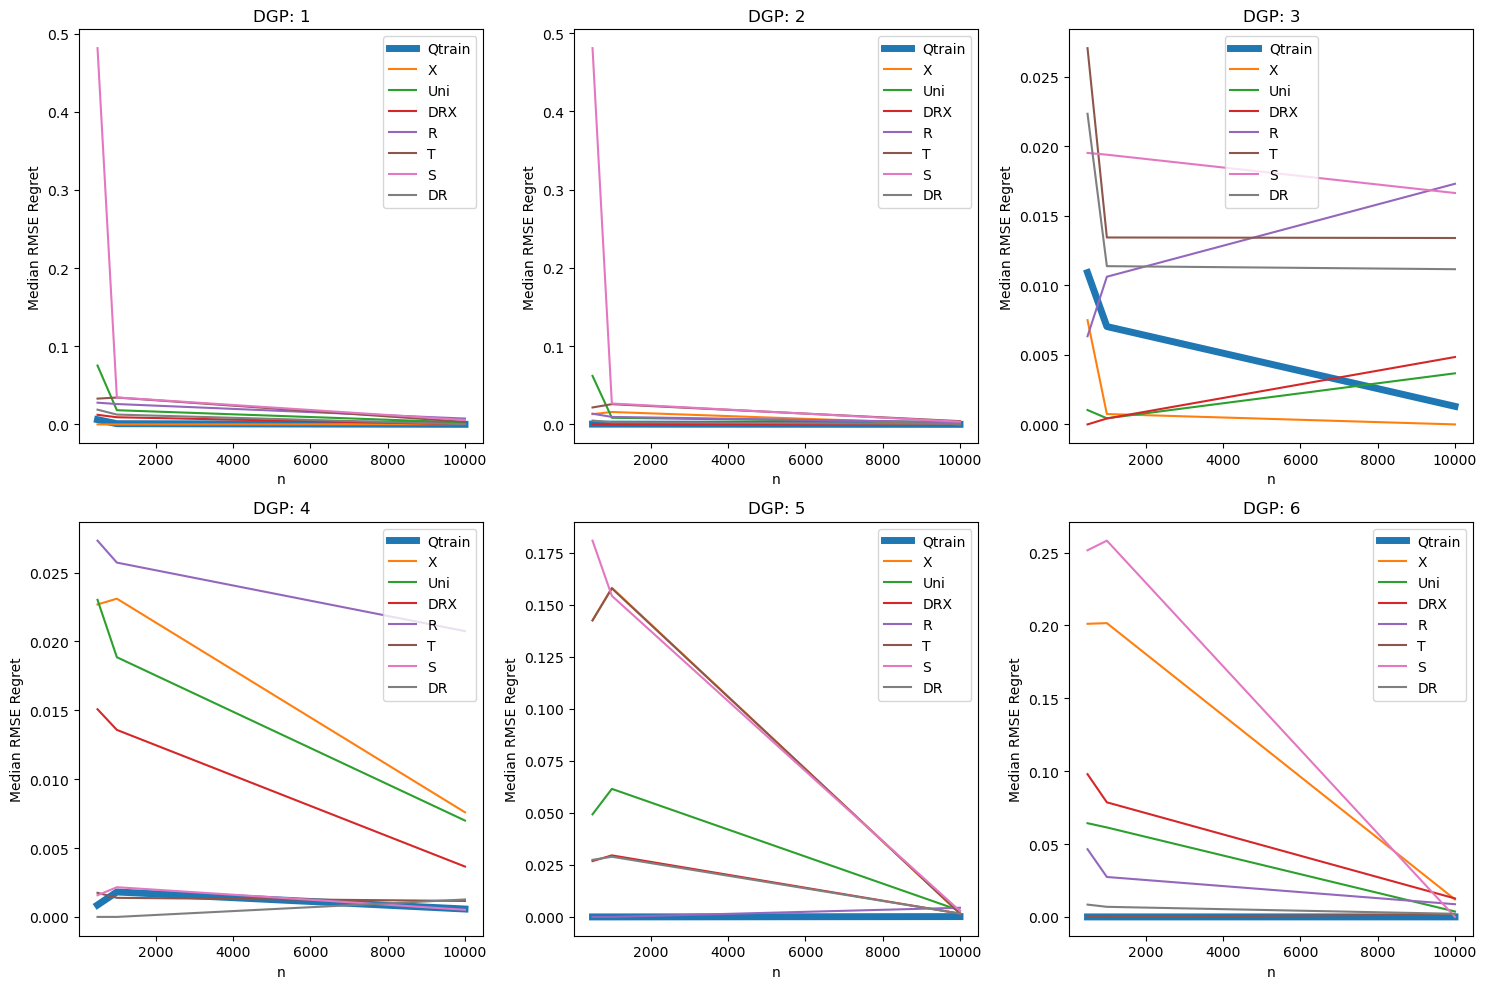

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
plt.figure(figsize=(15, 10))
it = 1
attr = 'median'
ylabel = 'Median RMSE Regret'
#all_results = joblib.load('all_results.jbl')
for dgp in np.arange(1, 7):
    rmses_agg = {}
    for n in [500, 1000, 10000]:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) - oracle
            rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                   'stderr': np.std(rmses) / np.sqrt(len(results)),
                                   'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                   '95': np.percentile(rmses, 95)}

    
    plt.subplot(2, 3, it)
    ngrid = [500, 1000, 10000]
    plt.plot(ngrid, [rmses_agg[n]['Qtrain'][attr] for n in ngrid], linewidth=5, label='Qtrain')
    for name in ['X', 'Uni', 'DRX', 'R', 'T', 'S', 'DR']:
        plt.plot(ngrid, [rmses_agg[n][name][attr] for n in ngrid], label=name)
    plt.title(f'DGP: {dgp}')
    plt.legend()
    plt.xlabel('n')
    plt.ylabel(ylabel)
    it += 1
plt.tight_layout()
plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
plt.show()

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

#all_results = joblib.load('all_results.jbl')
rmses_agg = {}
for dgp in np.arange(4, 7):
    rmses_agg[f'DGP {dgp}'] = {}
    for n in [500, 1000, 10000]:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[f'DGP {dgp}'][n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) - oracle
            rmses_agg[f'DGP {dgp}'][n][name] = f'{np.median(rmses):.2f} ({np.percentile(rmses, 95):.2f})'

    rmses_agg[f'DGP {dgp}'] = pd.DataFrame(rmses_agg[f'DGP {dgp}'])

table = pd.concat(rmses_agg, axis=1)

In [78]:
print(table.to_latex(multicolumn=True,bold_rows=True, multirow=True, column_format='r|ccc|ccc|ccc'))

\begin{tabular}{r|ccc|ccc|ccc}
\toprule
{} & \multicolumn{3}{l}{DGP 4} & \multicolumn{3}{l}{DGP 5} & \multicolumn{3}{l}{DGP 6} \\
{} &      500   &      1000  &      10000 &      500   &      1000  &      10000 &      500   &      1000  &      10000 \\
\midrule
\textbf{T        } &  0.00 0.01 &  0.00 0.01 &  0.00 0.00 &  0.14 0.18 &  0.16 0.19 &  0.00 0.01 &  0.00 0.00 &  0.00 0.00 &  0.00 0.00 \\
\textbf{S        } &  0.00 0.01 &  0.00 0.01 &  0.00 0.00 &  0.18 0.22 &  0.15 0.19 &  0.00 0.01 &  0.25 0.26 &  0.26 0.27 &  0.00 0.00 \\
\textbf{IPS      } &  0.11 0.13 &  0.10 0.13 &  0.05 0.08 &  0.06 0.12 &  0.07 0.14 &  0.03 0.06 &  0.03 0.05 &  0.02 0.04 &  0.01 0.01 \\
\textbf{DR       } &  0.00 0.01 &  0.00 0.00 &  0.00 0.01 &  0.03 0.07 &  0.03 0.06 &  0.00 0.01 &  0.01 0.03 &  0.01 0.02 &  0.00 0.01 \\
\textbf{R        } &  0.03 0.28 &  0.03 0.43 &  0.02 0.31 &  0.00 0.02 &  0.00 0.01 &  0.00 0.02 &  0.05 0.23 &  0.03 0.07 &  0.01 0.02 \\
\textbf{X        } &  0.02 0.03 &  0.02 0.0

C:\Users\bsyrg\AppData\Local\Temp\ipykernel_15744\1302902151.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(multicolumn=True,bold_rows=True, multirow=True, column_format='r|ccc|ccc|ccc'))


0.008757818895167975 X 0.0006650516999049407


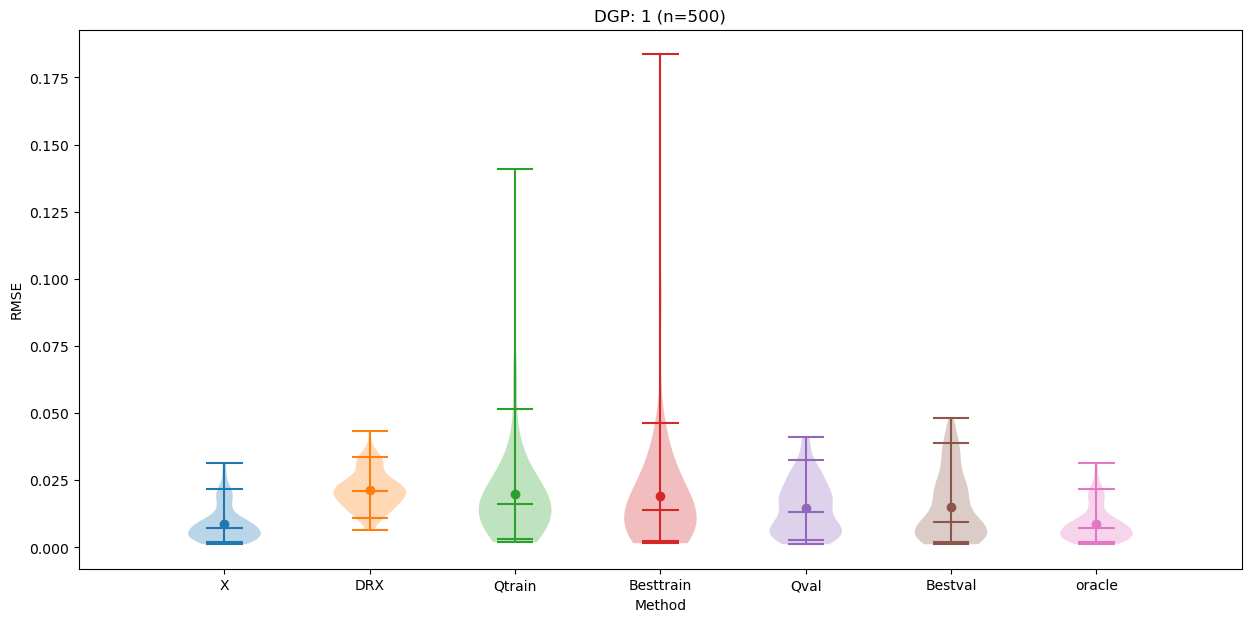

,mean,std,stderr,median
T,0.041116,0.003606,0.000361,0.040628
S,0.435804,0.108793,0.010879,0.494948
IPS,0.147076,0.043871,0.004387,0.140723
DR,0.028286,0.009578,0.000958,0.027029
R,0.087545,0.126566,0.012657,0.035086
X,0.008758,0.006651,0.000665,0.007089
DRX,0.021455,0.007089,0.000709,0.020866
Qtrain,0.019900,0.019369,0.001937,0.016239
Besttrain,0.019311,0.023415,0.002341,0.013978
Qval,0.014862,0.010129,0.001013,0.013358


0.030959791417377036 DRX 0.00078937470293166


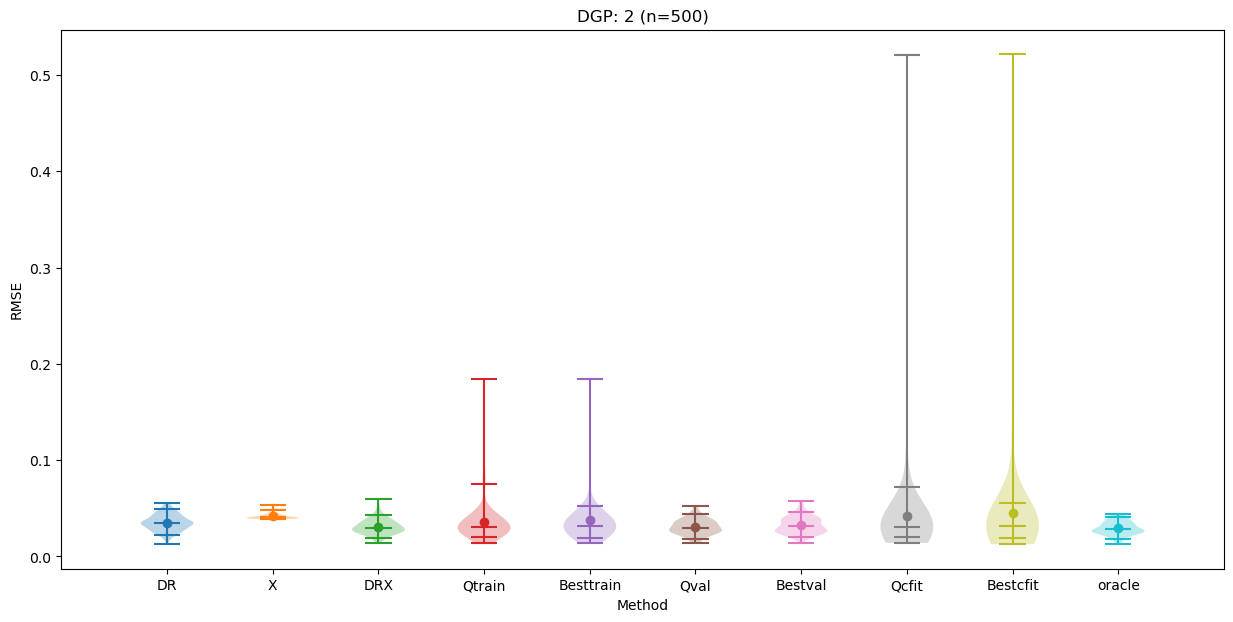

,mean,std,stderr,median
T,0.050549,0.002736,0.000274,0.050117
S,0.454502,0.112505,0.011251,0.516293
IPS,0.154340,0.043025,0.004303,0.145939
DR,0.035126,0.008378,0.000838,0.035055
R,0.097662,0.134612,0.013461,0.043721
X,0.041779,0.003028,0.000303,0.040516
DRX,0.030960,0.007894,0.000789,0.029480
Qtrain,0.036023,0.021376,0.002138,0.030974
Besttrain,0.038129,0.028022,0.002802,0.031751
Qval,0.030964,0.008010,0.000801,0.029913


0.02924988977873795 DRX 0.0007196747860449314


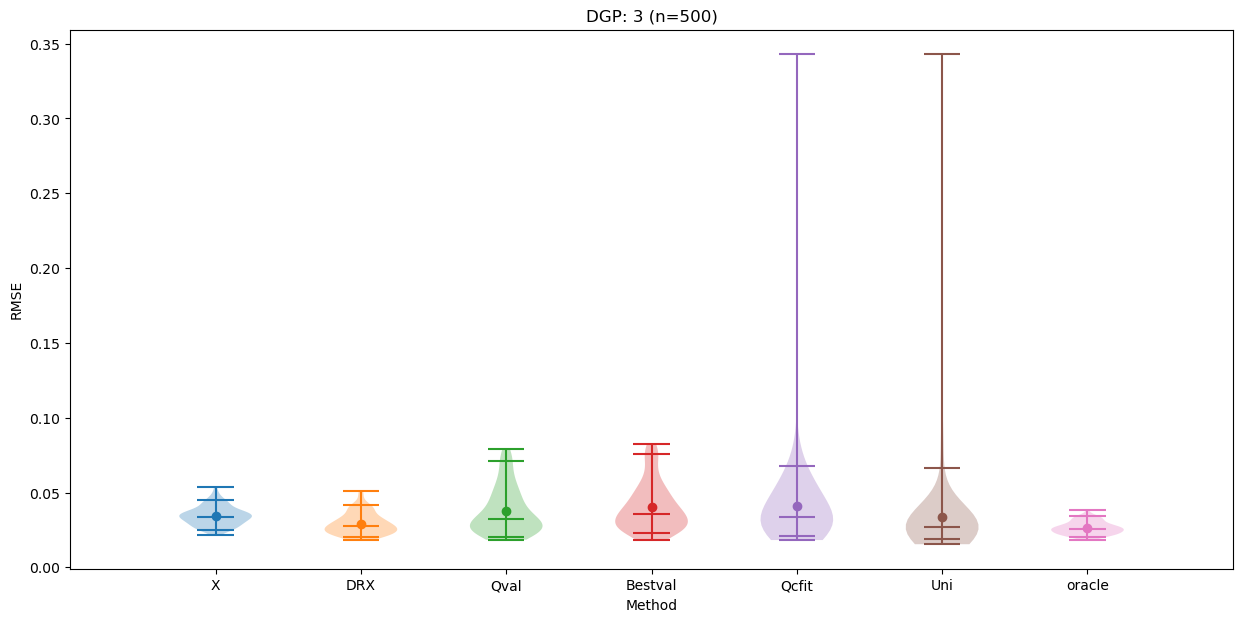

,mean,std,stderr,median
T,0.055070,0.016732,0.001673,0.053573
S,0.045610,0.009190,0.000919,0.045914
IPS,0.054359,0.011755,0.001176,0.055232
DR,0.051181,0.018281,0.001828,0.049832
R,0.098606,0.269594,0.026959,0.031608
X,0.034348,0.006388,0.000639,0.034000
DRX,0.029250,0.007197,0.000720,0.027409
Qtrain,0.064417,0.197034,0.019703,0.036461
Besttrain,0.070790,0.235558,0.023556,0.044340
Qval,0.037782,0.015546,0.001555,0.032134


0.02764898684769398 DR 0.000640723099995519


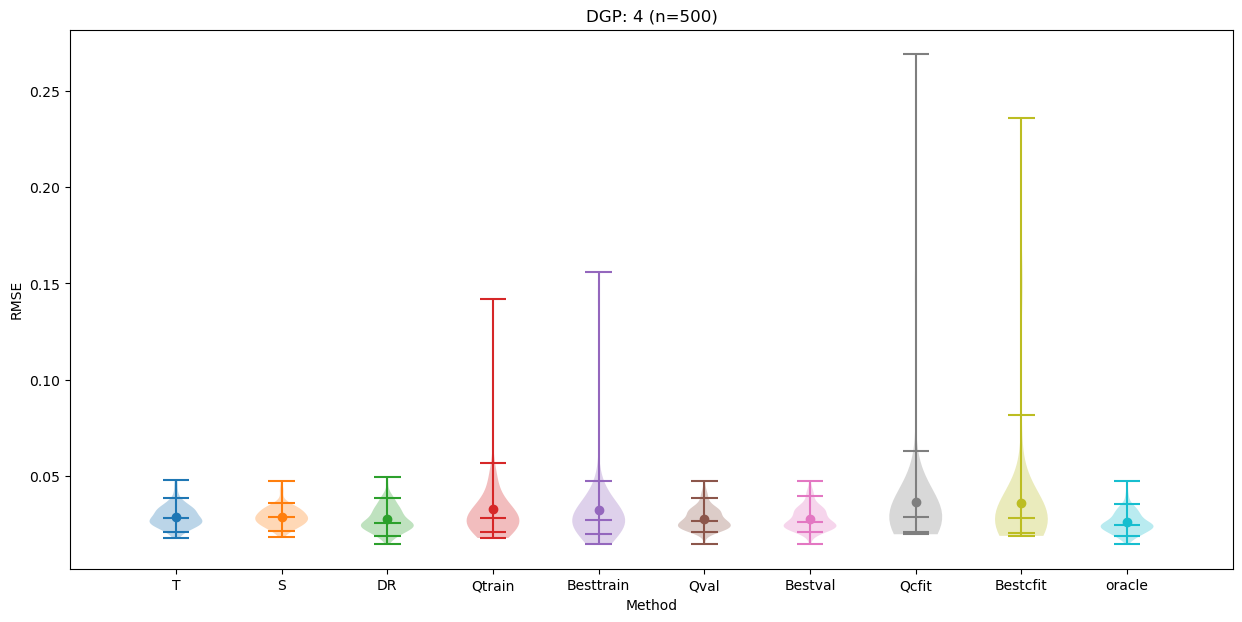

,mean,std,stderr,median
T,0.029095,0.005684,0.000568,0.028366
S,0.028989,0.005088,0.000509,0.028716
IPS,0.130991,0.024984,0.002498,0.137195
DR,0.027649,0.006407,0.000641,0.025814
R,0.134227,0.344106,0.034411,0.052683
X,0.049050,0.005698,0.000570,0.048401
DRX,0.041580,0.009581,0.000958,0.042402
Qtrain,0.033049,0.017716,0.001772,0.028232
Besttrain,0.032250,0.021638,0.002164,0.027170
Qval,0.028001,0.005686,0.000569,0.026753


0.09942829386605098 R 0.0036111537068758658


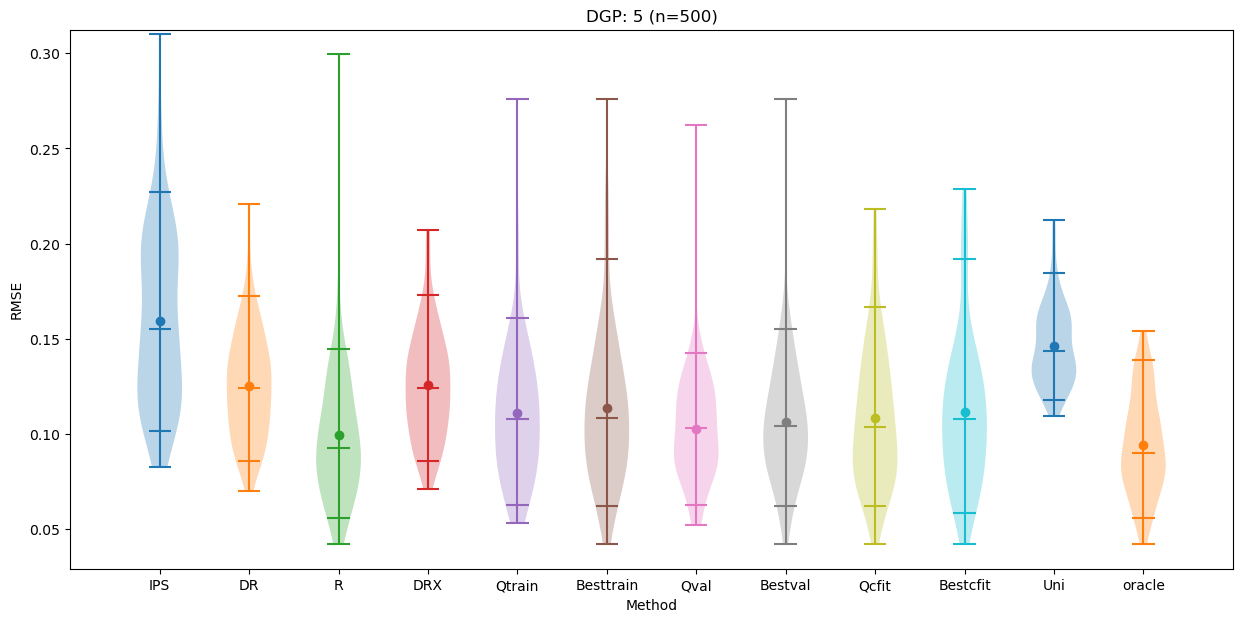

,mean,std,stderr,median
T,0.232924,0.006566,0.000657,0.231839
S,0.269328,0.011290,0.001129,0.273153
IPS,0.159540,0.045759,0.004576,0.155083
DR,0.125346,0.028417,0.002842,0.124022
R,0.099428,0.036112,0.003611,0.092709
X,0.233165,0.006520,0.000652,0.231294
DRX,0.125690,0.028585,0.002859,0.124076
Qtrain,0.111005,0.035903,0.003590,0.107892
Besttrain,0.113808,0.040672,0.004067,0.108320
Qval,0.102901,0.028584,0.002858,0.102924


0.02314570064551797 T 0.0007434448717684443


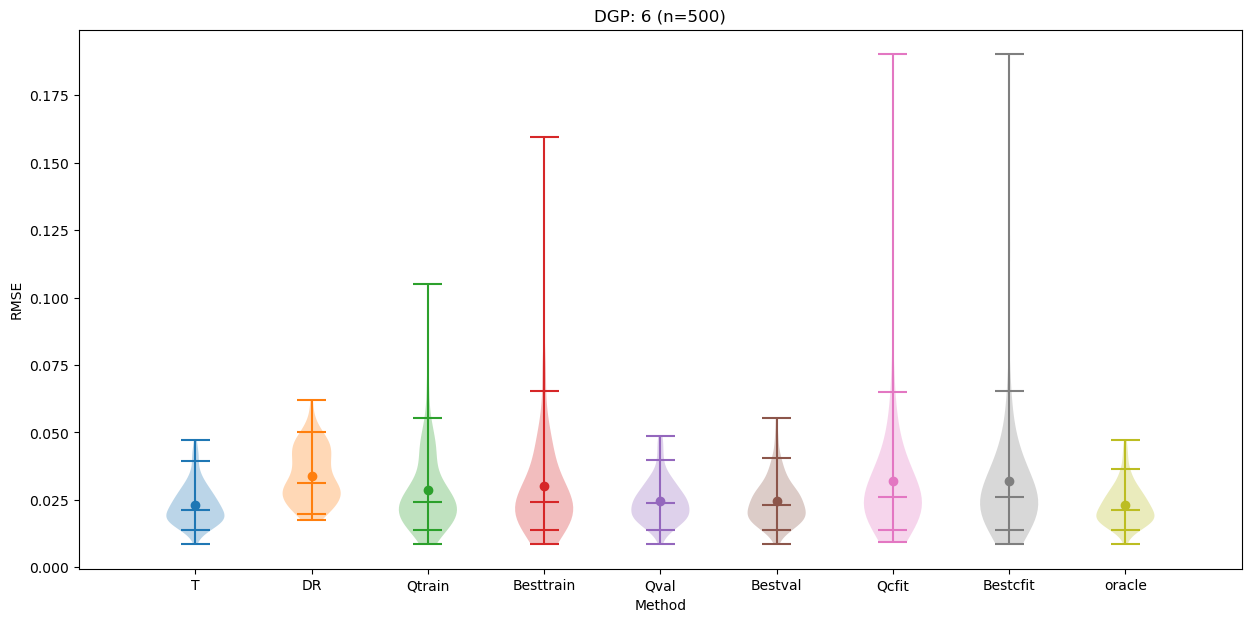

,mean,std,stderr,median
T,0.023146,0.007434,0.000743,0.021382
S,0.273827,0.002175,0.000217,0.273975
IPS,0.051842,0.012063,0.001206,0.051169
DR,0.033978,0.010021,0.001002,0.031254
R,0.098923,0.113751,0.011375,0.070447
X,0.223811,0.007280,0.000728,0.221929
DRX,0.120938,0.026844,0.002684,0.119213
Qtrain,0.028705,0.015707,0.001571,0.024093
Besttrain,0.030237,0.022092,0.002209,0.024093
Qval,0.024423,0.007803,0.000780,0.023849


0.006627985802401013 X 0.00037943528705567514


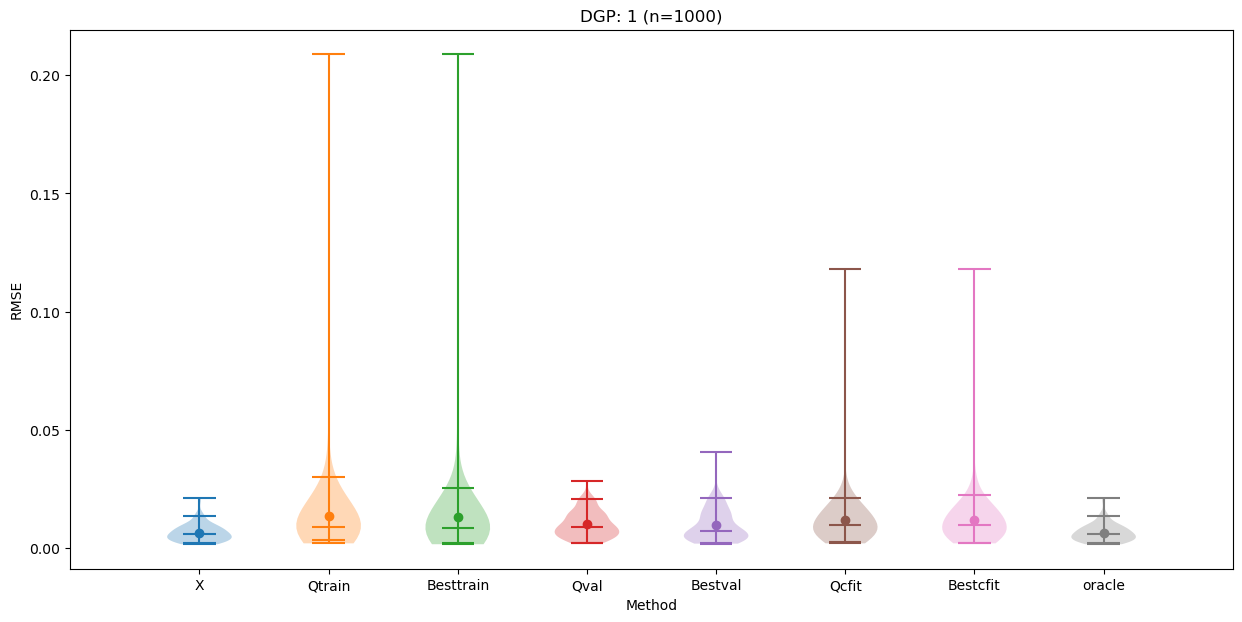

,mean,std,stderr,median
T,0.040275,0.002821,0.000282,0.040616
S,0.041243,0.004672,0.000467,0.040884
IPS,0.107081,0.028580,0.002858,0.104443
DR,0.020575,0.006631,0.000663,0.019082
R,0.055648,0.071270,0.007127,0.031836
X,0.006628,0.003794,0.000379,0.005928
DRX,0.016993,0.005644,0.000564,0.016187
Qtrain,0.013619,0.021133,0.002113,0.009143
Besttrain,0.013369,0.021719,0.002172,0.008395
Qval,0.010103,0.005604,0.000560,0.009009


0.025174305069472828 Qval 0.0005280749355109925


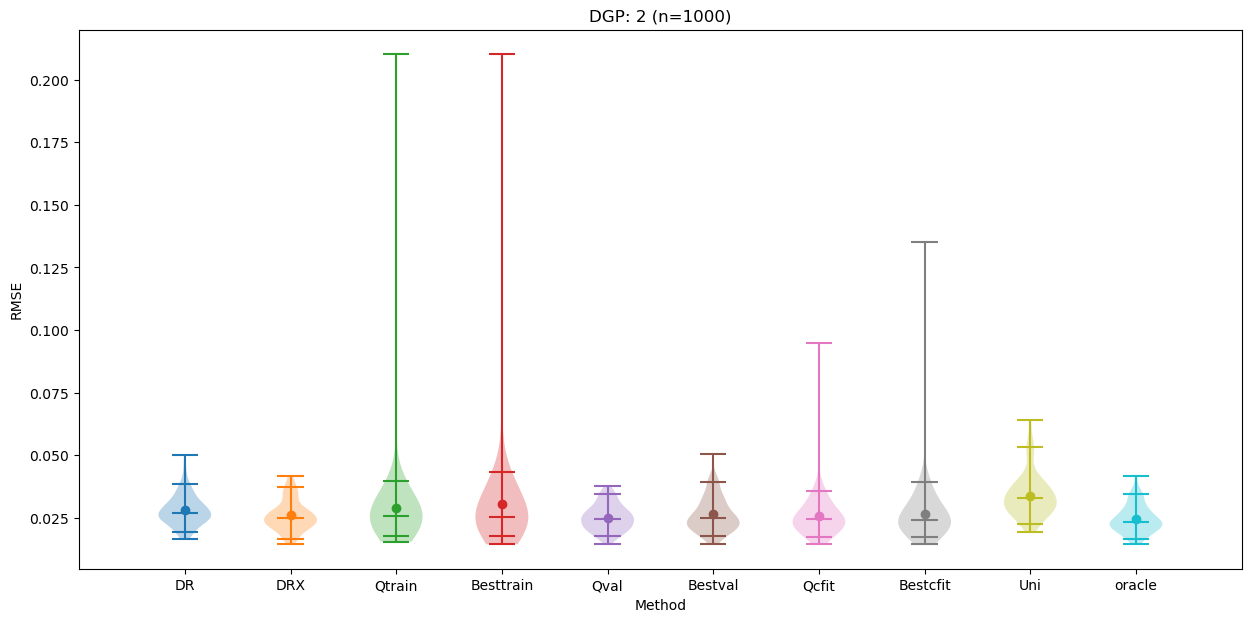

,mean,std,stderr,median
T,0.049736,0.002024,0.000202,0.049469
S,0.050918,0.004403,0.000440,0.050168
IPS,0.114083,0.028385,0.002838,0.111690
DR,0.028127,0.006189,0.000619,0.027126
R,0.057685,0.050582,0.005058,0.033710
X,0.039782,0.001879,0.000188,0.040041
DRX,0.026016,0.006042,0.000604,0.024966
Qtrain,0.028847,0.019607,0.001961,0.025914
Besttrain,0.030535,0.021931,0.002193,0.025473
Qval,0.025174,0.005281,0.000528,0.024721


0.024062278298537115 X 0.0005753650757937749


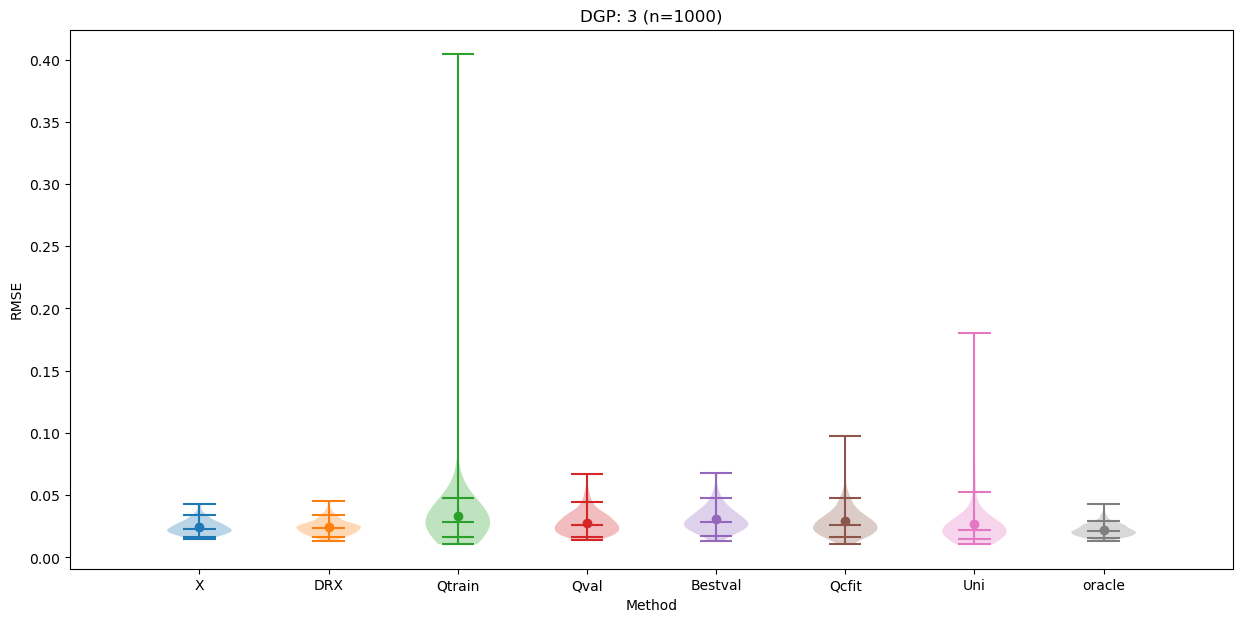

,mean,std,stderr,median
T,0.038436,0.011987,0.001199,0.035374
S,0.040682,0.008771,0.000877,0.041431
IPS,0.048164,0.014953,0.001495,0.046777
DR,0.036347,0.013270,0.001327,0.034582
R,0.078757,0.172278,0.017228,0.030879
X,0.024062,0.005754,0.000575,0.022886
DRX,0.024138,0.005851,0.000585,0.023875
Qtrain,0.033207,0.038570,0.003857,0.028040
Besttrain,0.041626,0.046306,0.004631,0.033231
Qval,0.027718,0.009527,0.000953,0.026216


0.024482603980706917 DR 0.00046398068589328337


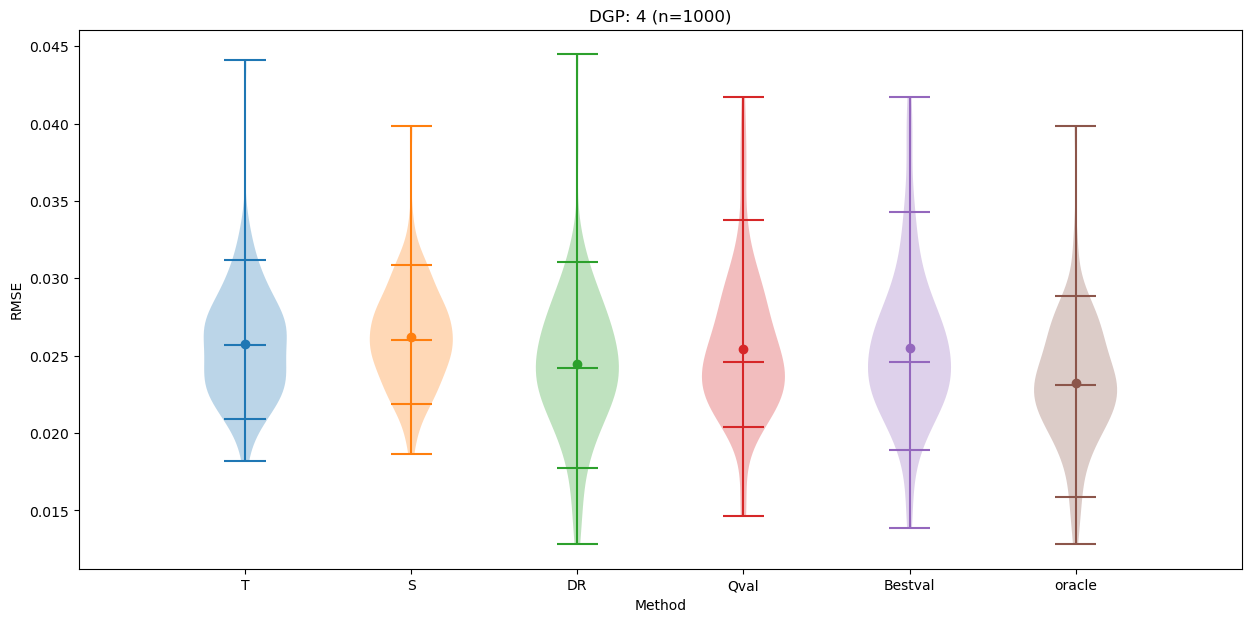

,mean,std,stderr,median
T,0.025725,0.003664,0.000366,0.025671
S,0.026234,0.003265,0.000327,0.025996
IPS,0.119699,0.024421,0.002442,0.118288
DR,0.024483,0.004640,0.000464,0.024184
R,0.137523,0.429534,0.042953,0.048916
X,0.045688,0.005143,0.000514,0.046291
DRX,0.036982,0.008723,0.000872,0.037601
Qtrain,0.036400,0.042520,0.004252,0.026793
Besttrain,0.044283,0.061523,0.006152,0.025720
Qval,0.025432,0.004656,0.000466,0.024608


0.07449936990241696 Qval 0.002127627298091332


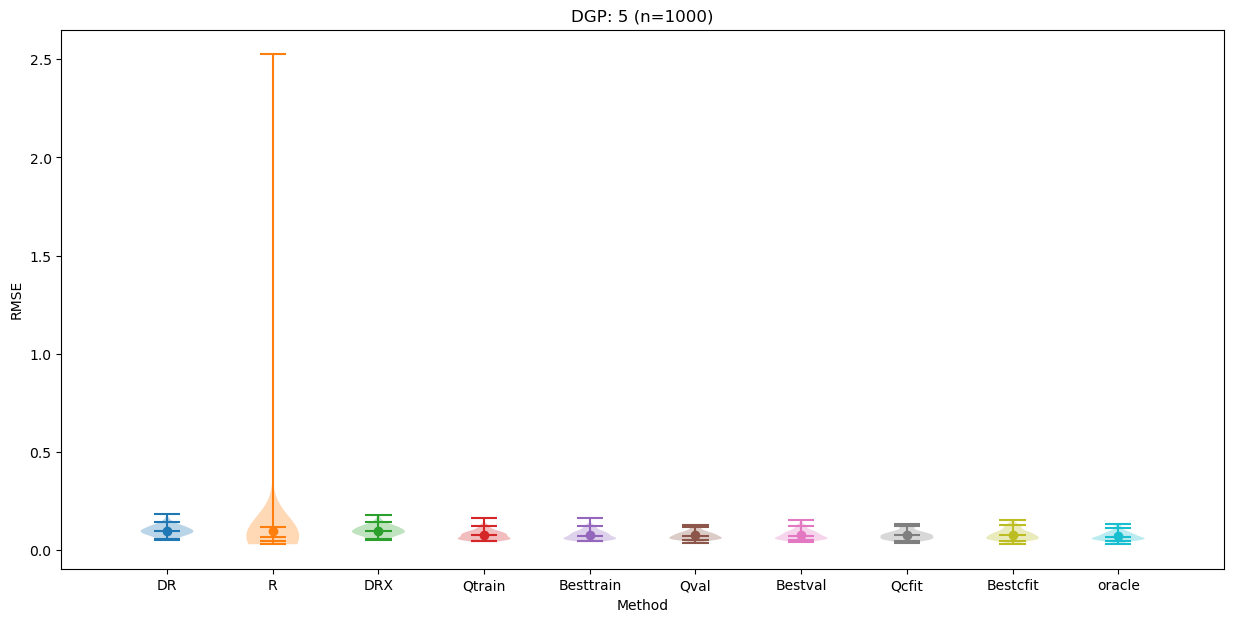

,mean,std,stderr,median
T,0.226212,0.012044,0.001204,0.229973
S,0.224852,0.013367,0.001337,0.229224
IPS,0.141763,0.040456,0.004046,0.136442
DR,0.098796,0.025904,0.002590,0.097368
R,0.094876,0.245234,0.024523,0.066421
X,0.226163,0.012106,0.001211,0.229795
DRX,0.098729,0.025924,0.002592,0.096672
Qtrain,0.075383,0.023072,0.002307,0.073758
Besttrain,0.075234,0.023369,0.002337,0.071095
Qval,0.074499,0.021276,0.002128,0.071095


0.01634320052728556 T 0.0004126701448937249


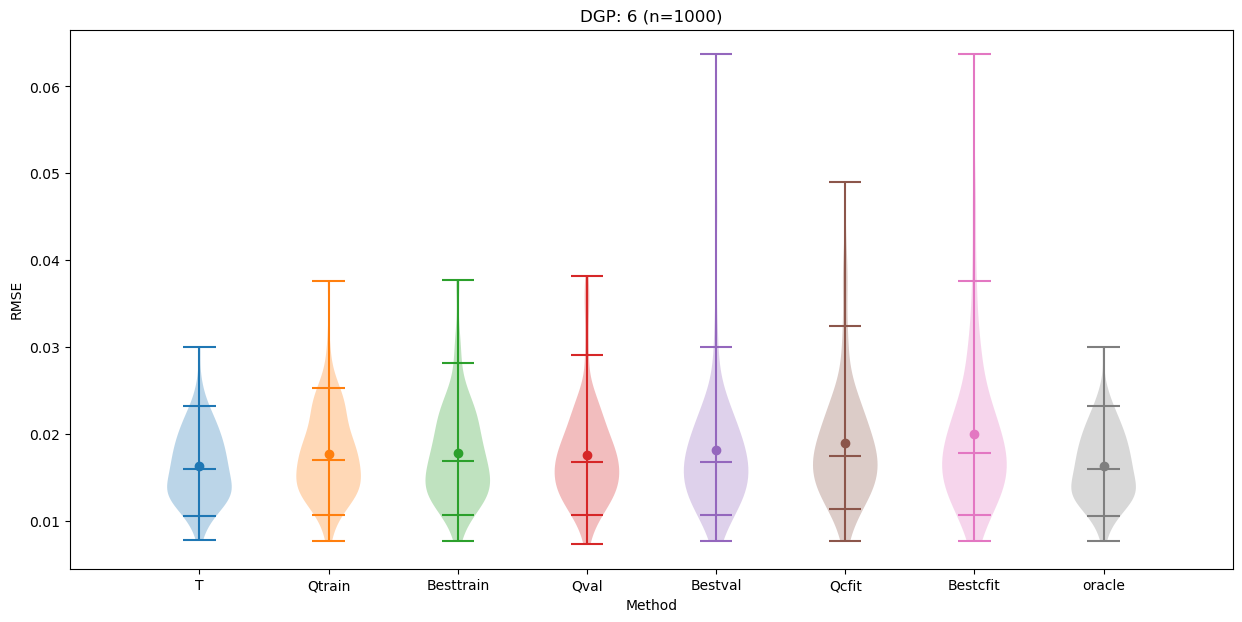

,mean,std,stderr,median
T,0.016343,0.004127,0.000413,0.015971
S,0.273969,0.002174,0.000217,0.274181
IPS,0.038120,0.009071,0.000907,0.036968
DR,0.025168,0.007361,0.000736,0.024198
R,0.078814,0.297113,0.029711,0.044583
X,0.214820,0.012264,0.001226,0.218433
DRX,0.094392,0.024744,0.002474,0.095135
Qtrain,0.017720,0.005006,0.000501,0.016991
Besttrain,0.017808,0.005602,0.000560,0.016905
Qval,0.017624,0.005628,0.000563,0.016846


0.0055033197838328515 Qcfit 0.00015738152179924412


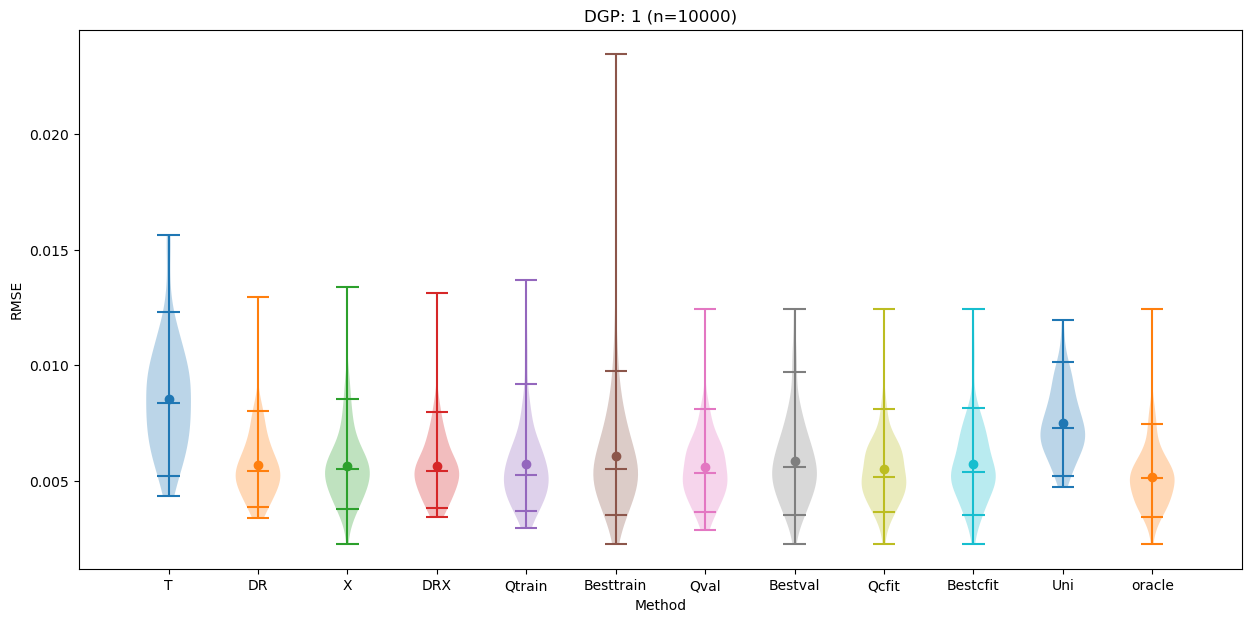

,mean,std,stderr,median
T,0.008554,0.002337,0.000234,0.008373
S,0.010663,0.001986,0.000199,0.010771
IPS,0.030510,0.005002,0.000500,0.030290
DR,0.005681,0.001481,0.000148,0.005428
R,0.013609,0.008683,0.000868,0.012614
X,0.005656,0.001611,0.000161,0.005501
DRX,0.005624,0.001492,0.000149,0.005402
Qtrain,0.005724,0.001869,0.000187,0.005266
Besttrain,0.006066,0.002541,0.000254,0.005490
Qval,0.005613,0.001605,0.000160,0.005351


0.008326633475368309 Qval 0.0002065236969114285


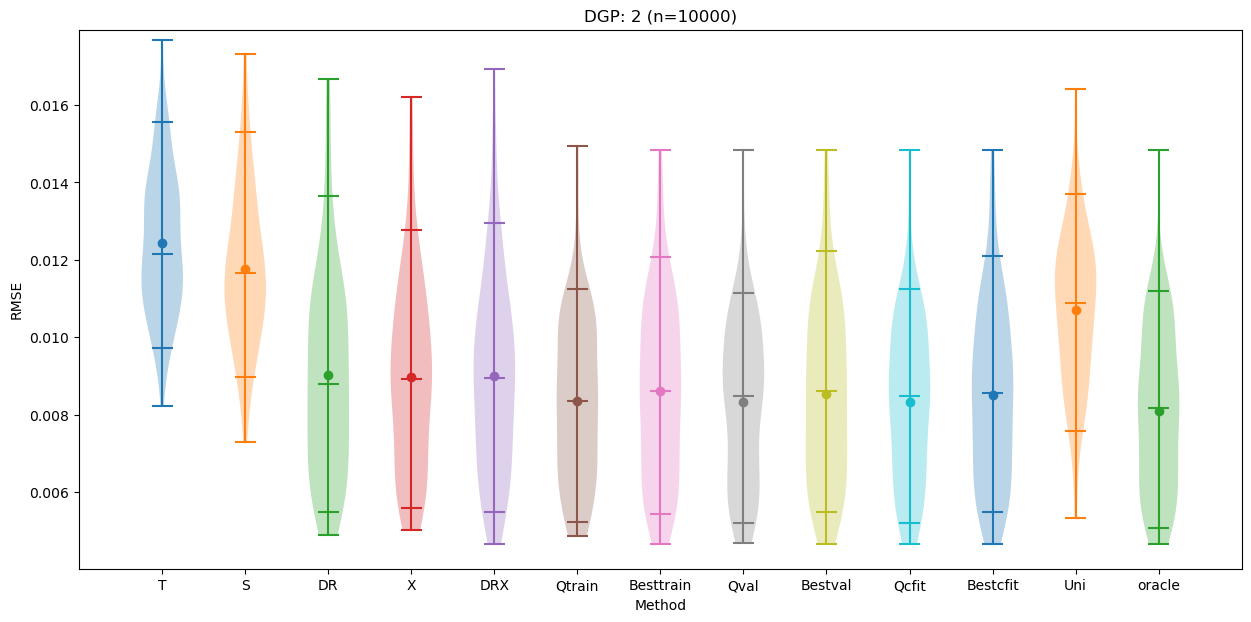

,mean,std,stderr,median
T,0.012430,0.001847,0.000185,0.012150
S,0.011764,0.002018,0.000202,0.011656
IPS,0.040624,0.006361,0.000636,0.040720
DR,0.009021,0.002608,0.000261,0.008783
R,0.015449,0.009005,0.000901,0.012313
X,0.008980,0.002421,0.000242,0.008918
DRX,0.008991,0.002498,0.000250,0.008933
Qtrain,0.008357,0.002092,0.000209,0.008340
Besttrain,0.008607,0.002296,0.000230,0.008620
Qval,0.008327,0.002065,0.000207,0.008489


0.01379716916109469 X 0.000379165934009187


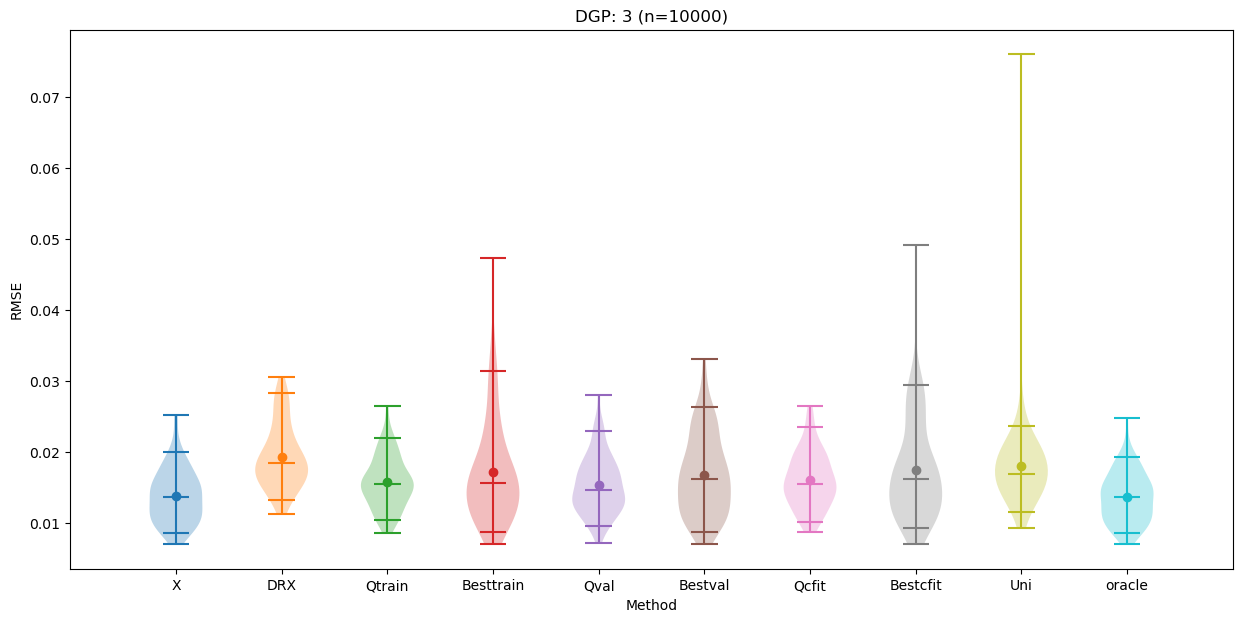

,mean,std,stderr,median
T,0.026499,0.004010,0.000401,0.026678
S,0.029511,0.004950,0.000495,0.030519
IPS,0.035499,0.012420,0.001242,0.033455
DR,0.024740,0.005127,0.000513,0.024183
R,0.036741,0.052464,0.005246,0.030209
X,0.013797,0.003792,0.000379,0.013705
DRX,0.019318,0.004492,0.000449,0.018430
Qtrain,0.015730,0.003658,0.000366,0.015431
Besttrain,0.017243,0.007164,0.000716,0.015591
Qval,0.015344,0.004037,0.000404,0.014586


0.017255069456010474 Qval 0.0002429018256025908


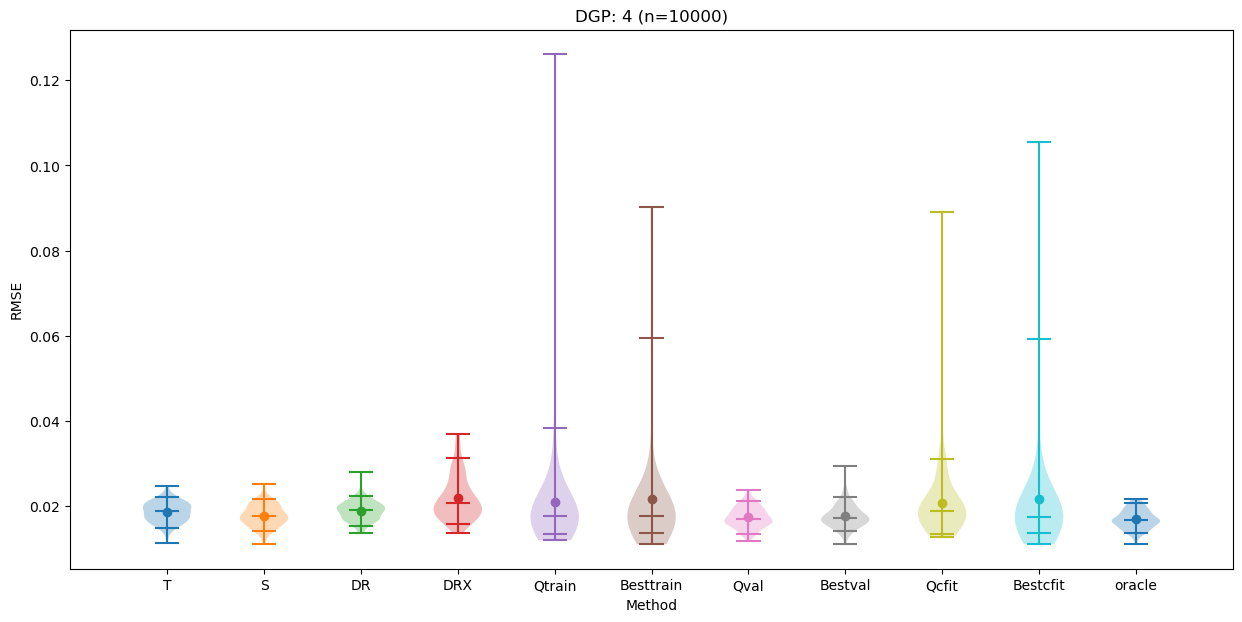

,mean,std,stderr,median
T,0.018499,0.002419,0.000242,0.018736
S,0.017687,0.002523,0.000252,0.017595
IPS,0.071238,0.013979,0.001398,0.068090
DR,0.018857,0.002371,0.000237,0.018916
R,0.088264,0.157903,0.015790,0.037949
X,0.028043,0.009264,0.000926,0.024474
DRX,0.021830,0.005133,0.000513,0.020644
Qtrain,0.020782,0.013794,0.001379,0.017669
Besttrain,0.021701,0.015065,0.001507,0.017612
Qval,0.017255,0.002429,0.000243,0.016979


0.018190242610610332 Qval 0.00062841298389363


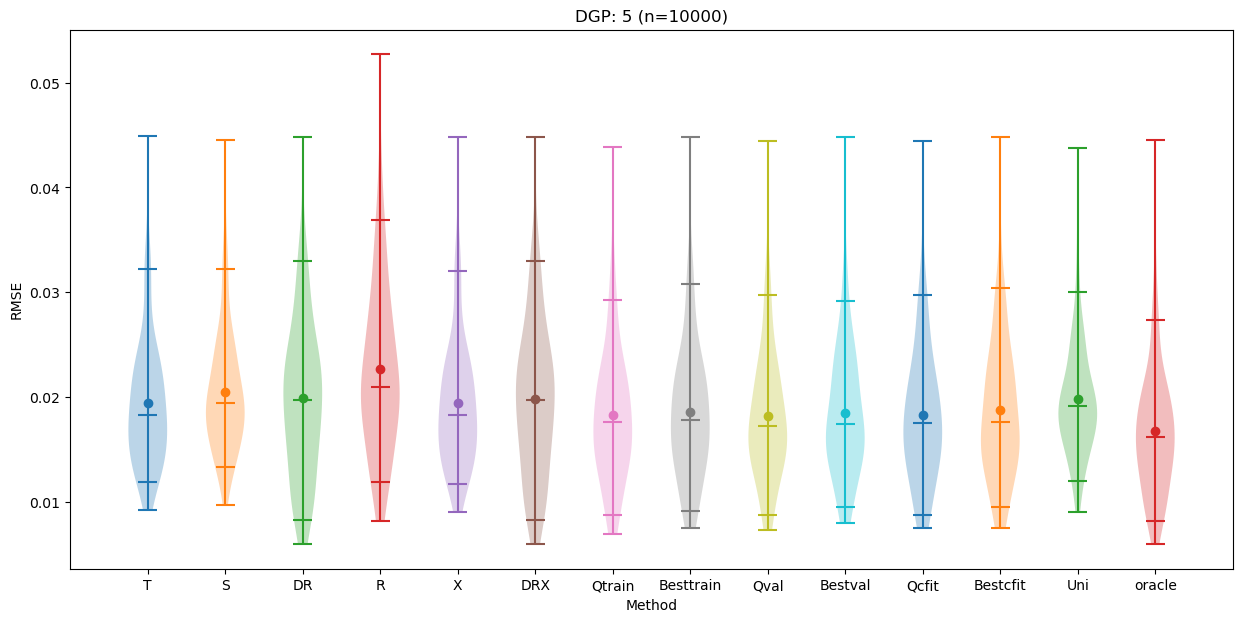

,mean,std,stderr,median
T,0.019435,0.006238,0.000624,0.018268
S,0.020502,0.005905,0.000590,0.019412
IPS,0.049490,0.016561,0.001656,0.046618
DR,0.019858,0.007464,0.000746,0.019753
R,0.022631,0.008174,0.000817,0.021000
X,0.019384,0.006253,0.000625,0.018245
DRX,0.019851,0.007458,0.000746,0.019753
Qtrain,0.018262,0.006395,0.000640,0.017585
Besttrain,0.018601,0.006523,0.000652,0.017850
Qval,0.018190,0.006284,0.000628,0.017196


0.0060567303790239465 S 0.0002620717450914435


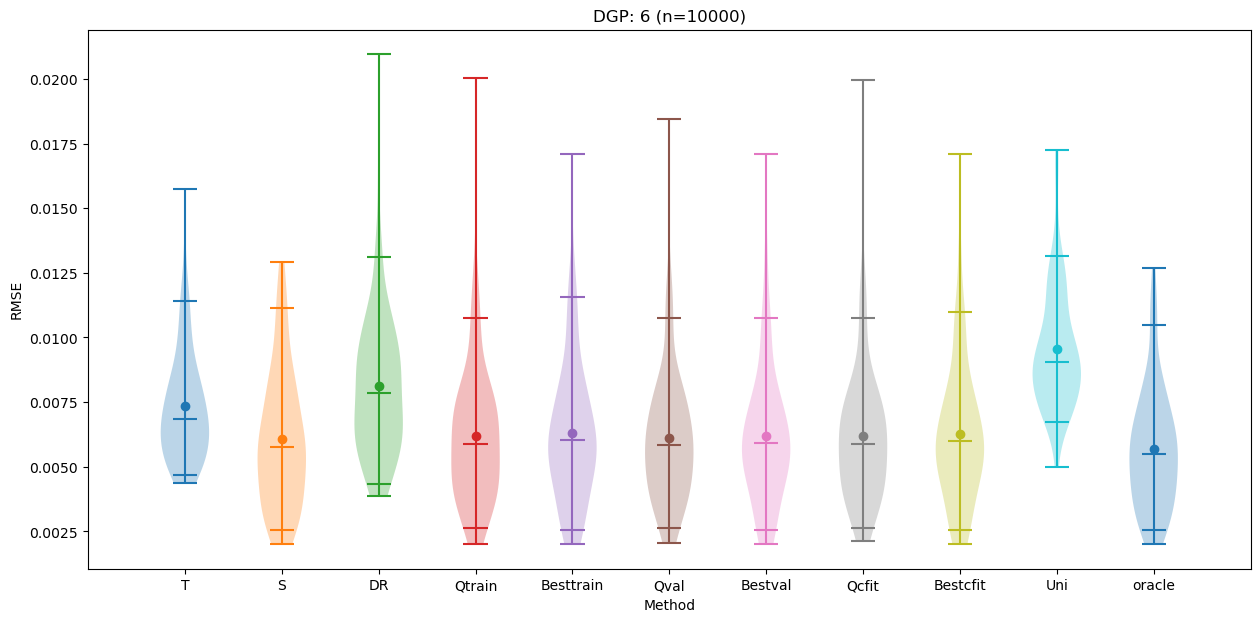

,mean,std,stderr,median
T,0.007336,0.002158,0.000216,0.006853
S,0.006057,0.002621,0.000262,0.005755
IPS,0.013889,0.004157,0.000416,0.013368
DR,0.008125,0.002782,0.000278,0.007843
R,0.016468,0.007473,0.000747,0.014774
X,0.018575,0.005724,0.000572,0.017729
DRX,0.019149,0.007828,0.000783,0.018499
Qtrain,0.006198,0.002730,0.000273,0.005881
Besttrain,0.006312,0.002735,0.000273,0.006029
Qval,0.006109,0.002574,0.000257,0.005847


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

#all_results = joblib.load('all_results.jbl')
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg = {}
        rmses_all = {}
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results]))
            # clip top 1% failure modes
#             q1 = np.percentile(rmses, 99)
#             rmses = rmses[(rmses<q1)]
            rmses_all[name] = rmses
            rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                               'stderr': np.std(rmses) / np.sqrt(len(results)),
                               'median': np.median(rmses)}

        agg_means = pd.DataFrame(rmses_agg).T['mean'].values
        min_rmse = np.min(agg_means)
        min_ind = np.argmin(agg_means)
        min_name = names[min_ind]
        min_rmse_std = rmses_agg[min_name]['stderr']
        print(min_rmse, min_name, min_rmse_std)
        
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        rmses_all['oracle'] = oracle
        rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                               'stderr': np.std(oracle) / np.sqrt(len(results)),
                               'median': np.median(oracle)}

        plt.figure(figsize=(15, 7))
        it = 0
        for name, agg in rmses_agg.items():
            mean = agg['mean']
            if mean >= min_rmse + 20*min_rmse_std:
                continue
            plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                           showextrema=True, quantiles=[.05, .95])
            plt.scatter(name, mean)
            it += 1
        plt.title(f'DGP: {dgp} (n={n})')
        plt.xlabel('Method')
        plt.ylabel('RMSE')
        plt.xlim([-1, it])
        plt.show()
        display(pd.DataFrame(rmses_agg).T)

# Experiments on Semi-Synthetic Data

In [6]:
data = 'welfare' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [7]:
mses, cates = experiment(data,
                         semi_synth=semi_synth,
                         simple_synth=simple_synth,
                         max_depth=max_depth,
                         scale=scale,
                         true_f=simple_true_cef,
                         random_state=1)

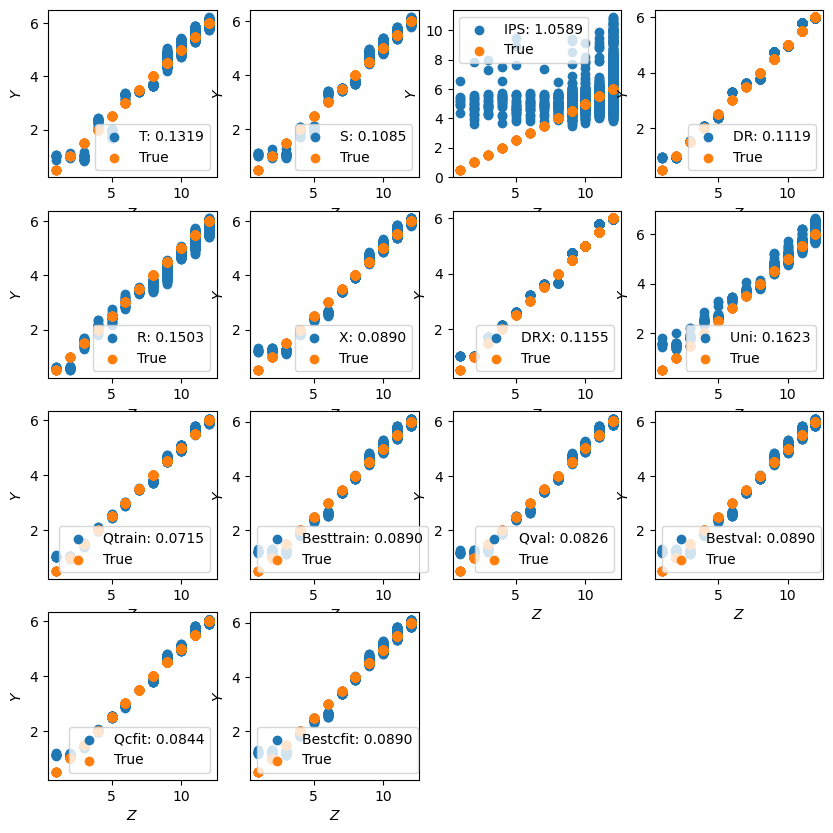

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(4, 4, it + 1)
    plt.scatter(cates['Ztest'][:, 1], cates[name], label=f'{name}: {np.sqrt(mse):.4f}')
    plt.scatter(cates['Ztest'][:, 1], cates['True'],  label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [9]:
results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(data,
                                                             semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             max_depth=max_depth,
                                                             scale=scale,
                                                             true_f=simple_true_cef,
                                                             random_state=it)
                                                  for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 84.5min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 85.2min finished


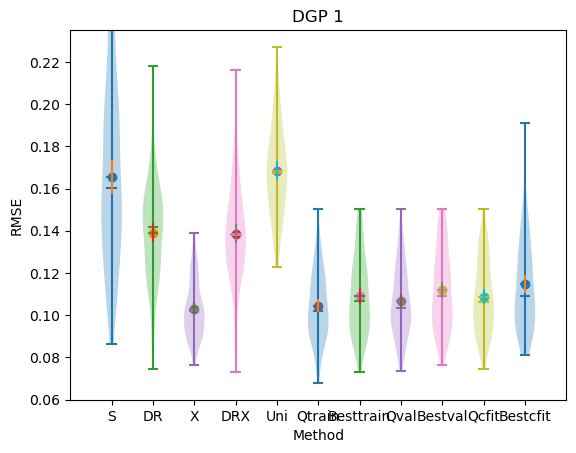

In [10]:
mses, _ = results[0]
names = list(mses.keys())
rmses_agg = {}
rmses_all = {}
for name in names:
    rmses = np.sqrt(np.array([r[0][name] for r in results]))
    # clip top 1% failure modes
    q1 = np.percentile(rmses, 99)
    rmses = rmses[(rmses<q1)]
    rmses_all[name] = rmses
    rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                       'median': np.median(rmses)}

agg_means = pd.DataFrame(rmses_agg).T['mean'].values
min_rmse = np.min(agg_means)
min_ind = np.argmin(agg_means)
min_name = names[min_ind]
min_rmse_std = rmses_agg[min_name]['stderr']
print(min_rmse, min_name, min_rmse_std)

oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                          if ((not name.startswith('Q')) and (not name.startswith('Best'))
                              and (not name.startswith('Uni')))]),
                axis=0)
rmses_all['oracle'] = oracle
rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                       'stderr': np.std(oracle) / np.sqrt(len(results)),
                       'median': np.median(oracle)}

plt.show()
it = 0
for name, agg in rmses_agg.items():
    mean = agg['mean']
    if mean >= min_rmse + 20*min_rmse_std:
        continue
    plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                   showextrema=True, quantiles=[.1, .9])
    plt.scatter(name, mean)
    it += 1
plt.title(f'DGP: {dgp} (n={n})')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xlim([-1, it])
plt.show()
display(pd.DataFrame(rmses_agg).T)